# Neural networks for flood prediction

<div style="background-color:#FFC5CB; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>

This notebook includes boxes with the formatting shown here to list the questions you are expected to answer in your report. You are not expected to write your answers here.

</div>

## Introduction

In this assignment, you will apply the techniques you learned for regression in a more realistic problem setting. You will use a synthetic dataset containing 5000 hypothetical cities, with the goal of **predicting the probability of flooding under heavy rainfall** given a diverse set of features ranging from geographical to policy-related. The goal is to give the model a number of examples for training and have it predict flooding probability for unseen cities.

We will use a neural network, also known as **Multilayer Perceptron (MLP)**, to map these features to flooding probability:

<div>
<center><img src="http://files.mude.citg.tudelft.nl/GA2.6/net.svg" width="600"/>
<figcaption><b>Figure 3.</b> Artificial neural network representation, with a zoomed-in view of how a single neuron works.</figcaption></center>
</div>

The assignment includes a series of tasks that will give you more intuition into how to work with neural networks:

- Data exploration, splitting and normalization
- Setting up a training loop with proper mini-batching and validation loss checks
- Feature exploration: which inputs are most important and how many to use?
- Hyperparameter exploration: how to avoid overfitting when the dataset is really small?

Let us explore each of these points in turn, and by the end you will be able to build simple neural networks for regression with confidence.

## Data Exploration

Let us first load a few packages, download the dataset and take a look at it:

In [1]:
import os
from urllib.request import urlretrieve
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%config InlineBackend.figure_formats = ['svg']

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Matplotlib created a temporary cache directory at /tmp/matplotlib-tds6d97i because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Download the dataset (if necessary)
filename = "flood_dataset.csv"
url = "http://files.mude.citg.tudelft.nl/GA2.6/" + filename

if not os.path.isfile(filename):
    print(f"Downloading {filename}...")
    urlretrieve(url, filename)

In [3]:
data = pd.read_csv(filename)

In [4]:
data.describe()

rainfall_mm  soil_permeability_mm_per_hr  impervious_surface_pct  \
count  5000.000000                  5000.000000             5000.000000   
mean   2234.643271                    25.432911               50.161499   
std    1009.844697                    14.108835               28.637033   
min     501.815605                     1.015407                0.001317   
25%    1355.428462                    13.182018               24.985991   
50%    2221.940145                    25.742230               50.516605   
75%    3120.314233                    37.373536               74.775715   
max    3999.178679                    49.998874               99.994726   

       groundwater_level_m  wetland_proximity_km  flood_defense_quality  \
count          5000.000000           5000.000000            5000.000000   
mean              5.042564             25.010688               0.504750   
std               2.915153             14.472669               0.287535   
min               0.000192              0.008559               0.000047   
25%               2.501051             12.511453               0.255574   
50%               5.097973             24.974793               0.502829   
75%               7.561161             37.867236               0.756919   
max               9.995590             49.999124               0.999957   

         slope_deg  zoning_regulation_strictness  flooding_probability  
count  5000.000000                   5000.000000           5000.000000  
mean     14.886441                      0.507124              0.445307  
std       8.643944                      0.290909              0.361374  
min       0.004278                      0.000027              0.012547  
25%       7.201130                      0.252997              0.099216  
50%      14.969796                      0.512453              0.347496  
75%      22.236174                      0.761736              0.832296  
max      29.993334                      0.999909              0.999998

Here we can see that we have 5000 samples in the dataset, with some features ranging between $[0,1]$ while others have broader ranges. The `flooding_probability` output has a $[0,1]$ range, as expected. In short, the potential features we can use to predict are:

- `rainfall_mm`: the amount of rain the city sees in a year
- `soil_permeability_mm_per_hr`: how porous the (uncovered) soil is
- `impervious_surface_pct`: how much of the city surface is impermeable
- `groundwater_level_m`: how close the groundwater level is to the surface
- `wetland_proximity_km`: how close the nearest wetland is to the city
- `flood_defense_quality`: how robust the flood prevention interventions applied to the city are
- `slope_deg`: a measure quantifying the average angle of natural slopes within the city
- `zoning_regulation_strictness`: how strictly zoning policies are followed in the city (e.g minimum requirements for park/green areas)

Let us now quickly plot each feature against `flooding probability` to see what we are dealing with:

In [5]:
target_col = 'flooding_probability'
features = [col for col in data.columns if col != target_col]

fig, axes = plt.subplots(2,4,figsize=(12,6))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].scatter(data[feature], data[target_col],s=0.5,alpha=0.6)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_col)

plt.tight_layout()

Take a look at the plots above and think about:

- How is the flooding probability distributed? Do you already see any patterns?
- Do all features correlate with the output in the same way?
- Do you expect any one feature to be enough to explain the probability of flooding?
- Which features look most important at first glance?

## Building and training a network with a single feature

Let us start with the most intuitive model, **mapping rainfall volume to flooding probability**. This means our network will have one input and one output. Let us first prepare the data.

### Prepare features and targets

From the `data` object above we can easily extract our feature and our target. Note how there is only one feature for now:

In [6]:
features = np.array([
                     data['rainfall_mm'],
                    ]).transpose()

targets = data['flooding_probability'].to_numpy().reshape(-1,1)

### Training-validation-test split and mini-batching

In the Programming Assignment this week you have seen how and why we split the dataset in three parts when using machine learning models. Here we do it again but this time more quickly:

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

<b>Task 1:</b>   


Use the `train_test_split` function from `sklearn.model_selection` to split our dataset. The dataset consists of `features` and `targets`.

The dataset should be split as follows:

- 80% of the data should go to the training set.
- 10% of the data should go to the validation set.
- 10% of the data should go to the test set.

This means that you should **use `train_test_split()` twice**, first to split training from validation+test and a second time to split validation from test. Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) of the function to see how the split sizes can be set up.

The splitting should be done in a way that shuffles the data first to ensure that the training, validation, and test sets are representative of the overall distribution of the data. The function takes a `random_state` integer that seeds shuffler to ensure that the results are reproducible; you can use the values 42 for the first split and 24 for the second split.

The resulting training, validation, and test sets should be stored in the variables `X_train`, `t_train`, `X_val`, `t_val`, `X_test`, and `t_test`.
</div>

In [7]:
X_train, X_val_test, t_train, t_val_test = train_test_split(features, targets, test_size=0.20, random_state=42)
X_val, X_test, t_val, t_test = train_test_split(X_val_test, t_val_test, test_size=0.50, random_state=24)

Next we implement a function that will split the training dataset into mini-batches. As we have seen in the lectures, this is a necessary step when training a neural network with Stochastic Gradient Descent (refer to the online book if needed).

In [8]:
def get_mini_batches(X, t, batch_size):
    """
    This function generates mini-batches from the given input data and labels.

    Parameters:
    X (numpy.ndarray): The features.
    t (numpy.ndarray): The targets corresponding to the input data.
    batchsize (int): The size of each mini-batch.

    Returns:
    list: A list of tuples where each tuple contains a mini-batch of the input data and the corresponding targets.
    """
    # Generate permutations
    perm = np.random.permutation(len(X))
    X_train_perm = X[perm]
    t_train_perm = t[perm]
    
    # Generate mini-batches
    X_batches = []
    t_batches = []
    for i in range(0, len(X_train_perm), batch_size):
        X_batches.append(X_train_perm[i:i+batch_size])
        t_batches.append(t_train_perm[i:i+batch_size])

    return list(zip(X_batches, t_batches))

The following figure illustrates both the way we split the original dataset and how we further split the training set into mini-batches:

<div>
<center><img src="http://files.mude.citg.tudelft.nl/GA2.6/splitting_minibatching.svg" width="600"/>
<figcaption><b>Figure 4.</b> Dataset splitting, mini-batching and the stochastic nature of MLP training.</figcaption></center>
</div>

### Normalization

Next we normalize our dataset. We have seen during our Workshop why that is an important step in training robust machine learning models. Here we will use the `MinMaxScaler` from scikit-learn, which scales the data between $0$ and $1$:

In [9]:
scaler_x = MinMaxScaler()
scaler_x.fit(X_train)

normalized_X_train = scaler_x.transform(X_train)
normalized_X_val = scaler_x.transform(X_val)

scaler_t = MinMaxScaler()
scaler_t.fit(t_train)

normalized_t_train = scaler_t.transform(t_train)
normalized_t_val = scaler_t.transform(t_val)

<div style="background-color:#FFC5CB; color: black; vertical-align: middle; width:90%; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>
    
1) Why should the `MinMaxScaler` be fitted on the training data only?

2) Why is it crucial that the exact same scaler is used to transform the validation dataset?

</div>

### Training

Now we define a function that will train the neural network for a number of epochs. First we define some training parameters:

- `learning_rate` (float): The learning rate of the optimizer ($\eta$ in the figure above), how much the network weights $\mathbf{w}$ will change in the direction of the gradient of the loss function;
- `n_epochs` (int): The number of epochs to train the model, i.e how many times the full training dataset will be seen by the network. For now we will only train the model for 20 epochs;
- `batch_size` (int): The size of each mini-batch ($\mathcal{B}$ in the figure above). A small portion of the training dataset. During training, each mini-batch is shown separately to the network until the end of the dataset is reached, marking one training epoch.

Then we build a function that implements a training loop. Review the pages on SGD and neural networks in the book if anything is unclear. We use the Mean Squared Error (**MSE**) loss function to drive the training, a natural choice that comes out directly from the probabilistic approach we used in class (refer to the slides and videos if needed). 

At every epoch, we loop through our mini-batches and update the network for each of them in turn. Crucially, we keep an eye on the validation error while we do this, in order to be able to detect overfitting:

In [10]:
def train_model(model, normalized_X_train, normalized_t_train, normalized_X_val, normalized_t_val, n_epochs, batch_size, learning_rate, verbose=True):
    """
    This function generates mini-batches from the given input data and labels.

    Parameters:
    model (sklearn.neural_network): The neural network model to be trained
    normalized_X_train (numpy.ndarray): Normalized network inputs (training set)
    normalized_t_train (numpy.ndarray): Normalized network targets (training set)
    normalized_X_val (numpy.ndarray): Normalized network inputs (validation set)
    normalized_t_val (numpy.ndarray): Normalized network target (validation set)
    n_epochs (int): Number of epochs the model will be trained for
    batch_size (int): The size of each mini-batch
    learning_rate (float): Factor multiplying loss gradients when updating network weights
    verbose (bool): Turns printing of losses at every epoch on or off

    Returns:
    train_loss_list: A list of training loss values, with n_epochs entries
    val_loss_list: A list of validation loss values, with n_epochs entries
    """
    
    # Initialize lists for loss values
    epoch_list = []
    train_loss_list = []
    val_loss_list = []
    model.learning_rate_init = learning_rate

    # Frequency for logging the losses
    N_print = 10**(int(np.log10(n_epochs)) - 1)

    # Fix random seed for reproducibility
    np.random.seed(42)
    
    for epoch in range(n_epochs):
        
        # Generate mini-batches
        mini_batches = get_mini_batches(normalized_X_train, normalized_t_train, batch_size)
        
        # Train model on mini-batches
        for X_batch, t_batch in mini_batches:
            model.partial_fit(X_batch, t_batch.flatten())
        
        if epoch%N_print==0 or epoch==n_epochs-1: 
            epoch_list.append(epoch)
            
            # Compute loss on training set
            train_loss = mean_squared_error(normalized_t_train, model.predict(normalized_X_train))
            train_loss_list.append(train_loss)
            
            # Compute loss on validation set
            val_loss = mean_squared_error(normalized_t_val, model.predict(normalized_X_val))
            val_loss_list.append(val_loss)

            if verbose:
                print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss_list[-1]:.7f} - Val Loss: {val_loss:.7f}")
        
    return epoch_list, train_loss_list, val_loss_list


<div style="background-color:#FFC5CB; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>
    
3) The `train_model` function tracks the MSE loss for both training and validation datasets. In a case of extreme overfitting, what would you expect to happen with the training loss? What about the validation loss?

4) Looking at the loop in `train_model`, training progresses all the way until `n_epochs` is reached, regardless of how the validation loss is evolving. This makes the training prone to overfitting. Briefly explain in words how you could modify the code above in order to implement Early Stopping.

</div>

### Construct a neural network model

Note how in `train_model` we rely on a `model` object that has:

- A `predict` method that computes $y$ as a function of $\mathbf{x}$ or multiple predictions stacked in a vector $\mathbf{y}$ as a function of inputs $\mathbf{X}$ stacked in matrix form
- A `partial_fit` function that performs the SGD update $\mathbf{w}_\mathrm{new} = \mathbf{w}_\mathrm{old} - \eta\nabla E_\mathcal{B}$ based on a mini-batch.

Scikit-learn provides such a model implementing a simple feed-forward neural network with the `MLPRegressor` class. It takes the architecture of the network (number of hidden layers, number of neurons) and the activation function of the hidden layers as input, and outputs a model object.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2:</b>   
    
You are tasked with setting up a Multi-Layer Perceptron (MLP). The MLP should have the following characteristics:

 - The hidden layer sizes are defined as a tuple. For this task we want to have two hidden layers with 10 and 5 neurons, respectively, so we should write: `hidden_layer_sizes=(10,5)`. Notice that we only specify the hidden layer sizes, the input and output sizes will be automatically inferred when we train the model. 
 - The class provides several options for activation function, but in this assignment we will set it to `activation='relu'`

The configured `MLPRegressor` should be stored in a variable named `model`. We then call the training function we defined above and pass this model as argument.

Training neural networks is a stochastic operation: the MLP is given **random initial weights** and SGD is random by nature. If you want to make sure you always get the same trained network every time you run the notebook (e.g. for comparison reasons), you can pass `random_state=0` (or some other integer) to `MLPRegressor`
</div>

In [11]:
model = MLPRegressor(hidden_layer_sizes = (10, 5), 
                    activation = 'relu',
                    random_state=0)

### Train the network and track its learning progress

First of all we train the network you just defined above:

<div style="background-color:#facb8e; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>

<b>Tip:</b>

If you run this code block twice you will just continue training the same network. If you want to train from zero again you should also rerun the cell above where the model is created.
</p>
</div>

In [12]:
epoch_list, train_loss_list, val_loss_list = train_model(model, 
                                                         normalized_X_train, 
                                                         normalized_t_train, 
                                                         normalized_X_val, 
                                                         normalized_t_val, 
                                                         n_epochs=100, 
                                                         batch_size=64, 
                                                         learning_rate=0.001
                                                        )

Epoch 1/100 - Train Loss: 0.9385475 - Val Loss: 0.8988853
Epoch 11/100 - Train Loss: 0.2377800 - Val Loss: 0.2187144
Epoch 21/100 - Train Loss: 0.1405309 - Val Loss: 0.1359003
Epoch 31/100 - Train Loss: 0.1176267 - Val Loss: 0.1143961
Epoch 41/100 - Train Loss: 0.1101738 - Val Loss: 0.1080991
Epoch 51/100 - Train Loss: 0.1078050 - Val Loss: 0.1063523
Epoch 61/100 - Train Loss: 0.1076643 - Val Loss: 0.1067786
Epoch 71/100 - Train Loss: 0.1072867 - Val Loss: 0.1065223
Epoch 81/100 - Train Loss: 0.1073285 - Val Loss: 0.1065166
Epoch 91/100 - Train Loss: 0.1073654 - Val Loss: 0.1067272
Epoch 100/100 - Train Loss: 0.1072595 - Val Loss: 0.1066012


<div style="background-color:#AABAB2; color: black; width:90%;  vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 3:</b>  
    
Use the block below to plot the validation and training loss curves. Add this plot to your report.

</div>

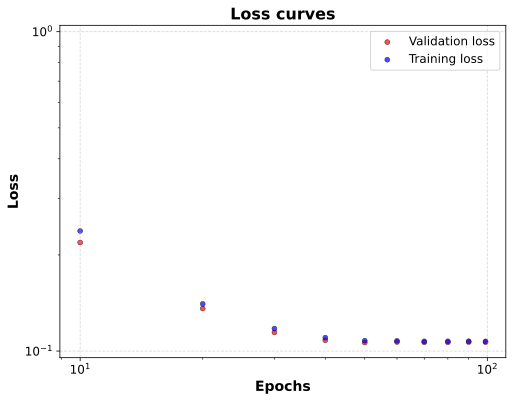

In [13]:
# Initialize figure
ax = plt.figure(figsize=(8, 6)).gca()

# Create a scatter plot
plt.scatter(epoch_list, val_loss_list, label='Validation loss', color='red', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)
plt.scatter(epoch_list, train_loss_list, label='Training loss', color='blue', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)

# Add labels and a legend
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Loss curves', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)

# Switch to log-log plot
plt.yscale('log')
plt.xscale('log')

# Customize the grid appearance
plt.grid(True, linestyle='--', alpha=0.5)

# Customize the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Wrap up
plt.show()

<div style="background-color:#FFC5CB; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>
    
5) Look at how both loss curves behave in the plot above. Is the model overfitting? Is the network learning during the training process? Is there a need to use more epochs for this particular model?

</div>

### Evaluate network performance

We can also look at how well the model performs. Since we only have one input feature and it is normalized in the $[0,1]$ range, we can easily set a `linspace` in the same range and compute $y(x)$ for all of them.

Note how in the code below we de-normalize $\mathbf{X}$ and also $\mathbf{y}$, for plotting. The raw output values that come out of the network are not human-readable since it was trained on normalized targets.

In [14]:
# Create a linspace in the normalized x space, scale it back for plotting
normalized_X_range = np.linspace(0,1,100).reshape(-1,1)
X_range = scaler_x.inverse_transform(normalized_X_range)

# Feed normalized X to the network and collect normalized y values. Then scale them back for plotting
normalized_y_range = model.predict(normalized_X_range).reshape(-1,1)
y_range = scaler_t.inverse_transform(normalized_y_range)

Now we just plot everything in two separate plots, first together with the training data and then with the validation data:

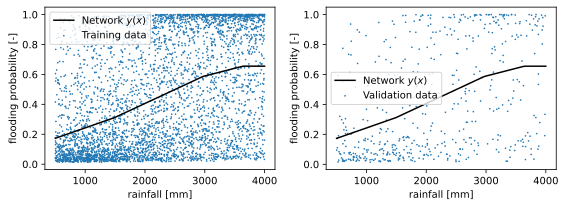

In [15]:
fig,axes = plt.subplots(1,2,figsize=(8,3))

# Plot predictions in black, together with all training data
axes[0].plot(X_range, y_range, label=r"Network $y(x)$", color='k')
axes[0].scatter(X_train,t_train,s=0.5, label='Training data')
axes[0].set_xlabel('rainfall [mm]')
axes[0].set_ylabel('flooding probability [-]')

# Plot predictions in black, together with all validation data
axes[1].plot(X_range, y_range,label=r"Network $y(x)$", color='k')
axes[1].scatter(X_val,t_val,s=0.5, label='Validation data')
axes[1].set_xlabel('rainfall [mm]')
axes[1].set_ylabel('flooding probability [-]')

# Wrap up
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

Another convenient way to evaluate performance is through a **parity plot**. This consists in plotting targets on the x-axis against network predictions on the y-axis, in other words a $t$ versus $y$ plot. For a model that always makes perfect predictions, $y=t$ for all instances of the target, which would make all points in the plot lie on the diagonal line $y=x$. In practice model predictions are often far from perfect, and this deviation would be seen as the points drifting away from the diagonal.

The following block will do that for you:

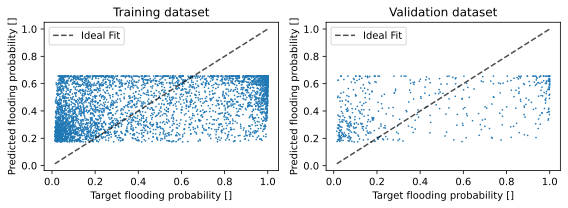

In [16]:
# Compute y for the whole training dataset and then denormalize it for plotting
y_train = scaler_t.inverse_transform(model.predict(normalized_X_train).reshape(-1,1))

# Compute y for the whole validation dataset and then denormalize it for plotting
y_val = scaler_t.inverse_transform(model.predict(normalized_X_val).reshape(-1,1))

# Set up the plots
fig,axes = plt.subplots(1,2,figsize=(8,3))

axes[0].set_title('Training dataset')
axes[0].set_xlabel('Target flooding probability []')
axes[0].set_ylabel('Predicted flooding probability []')

axes[1].set_title('Validation dataset')
axes[1].set_xlabel('Target flooding probability []')
axes[1].set_ylabel('Predicted flooding probability []')

# Plot predictions versus targets for both sets
axes[0].scatter(t_train,y_train,s=0.5)
axes[1].scatter(t_val,y_val,s=0.5)

# Plot 'ideal fit' diagonal lines
min_val = min(np.min(t_train), np.min(y_train))
max_val = max(np.max(t_train), np.max(y_train))
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[0].legend()

min_val = min(np.min(t_val), np.min(y_val))
max_val = max(np.max(t_val), np.max(y_val))
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[1].legend()

# Wrap up
plt.tight_layout()
plt.show()

<div style="background-color:#FFC5CB; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>
    
6) Look at the parity plots above for the one-feature model. We see that the model is not doing well. Is the model overfitting or underfitting? Why is this happening? Consider the plotted dataset at the top of the notebook to justify your answer.

7) Are there cities for which even this model gives reasonable flooding probability predictions? Use your parity plots to motivate your answer.

</div>

## Improving the model by adding input features

We might be able to improve on the model by adding input features. Repeat the process above until you reach a powerful model for flooding prediction.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

<b>Task 4:</b>

Use this block to set up a new neural network that now takes **up to five features** as inputs. See if you can **reach a validation loss lower than $0.001$**

Remember you need to (i) split your dataset again since it has changed; (ii) normalize features and targets; (iii) adjust the number of epochs until you are sure the model has finished training; (iv) set up an `MLPRegressor` and call `train_model`.

Since you are now fitting a more complex function you will need a more complex network. Use a network with **three hidden layers** with **50 units each** for this task. The activation function should remain `relu`.

With your final network, generate training and validation parity plots and add them to your report. Since this model has more features, the first plotting strategy using `linspace` is not very informative, so stick to just parity plots.
</div>

<div style="background-color:#facb8e; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>

<b>Tip:</b>

You can do this quickly by copy/pasting code from previous tasks. To avoid problems with running code blocks out of order, make sure all necessary steps are in the same code block.
</p>
</div>

Epoch 1/500 - Train Loss: 0.0224080 - Val Loss: 0.0209720
Epoch 11/500 - Train Loss: 0.0026915 - Val Loss: 0.0022452
Epoch 21/500 - Train Loss: 0.0011204 - Val Loss: 0.0010806
Epoch 31/500 - Train Loss: 0.0008271 - Val Loss: 0.0008336
Epoch 41/500 - Train Loss: 0.0006811 - Val Loss: 0.0007409
Epoch 51/500 - Train Loss: 0.0006635 - Val Loss: 0.0007756
Epoch 61/500 - Train Loss: 0.0006368 - Val Loss: 0.0007190
Epoch 71/500 - Train Loss: 0.0005574 - Val Loss: 0.0006362
Epoch 81/500 - Train Loss: 0.0005675 - Val Loss: 0.0007090
Epoch 91/500 - Train Loss: 0.0008462 - Val Loss: 0.0008779
Epoch 101/500 - Train Loss: 0.0005343 - Val Loss: 0.0007286
Epoch 111/500 - Train Loss: 0.0004929 - Val Loss: 0.0006705
Epoch 121/500 - Train Loss: 0.0005426 - Val Loss: 0.0006752
Epoch 131/500 - Train Loss: 0.0004622 - Val Loss: 0.0006217
Epoch 141/500 - Train Loss: 0.0005578 - Val Loss: 0.0007577
Epoch 151/500 - Train Loss: 0.0003844 - Val Loss: 0.0005973
Epoch 161/500 - Train Loss: 0.0004469 - Val Loss: 0

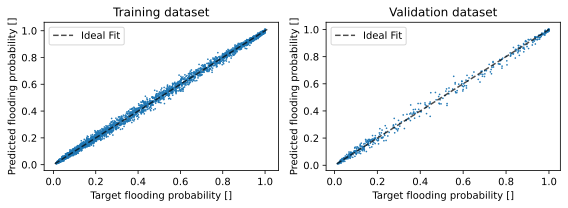

In [17]:
features = np.array([
                     data['rainfall_mm'],
                     data['flood_defense_quality'],
                     data['impervious_surface_pct'],
                     data['soil_permeability_mm_per_hr'],
                     data['groundwater_level_m']
                    ]).transpose()

targets = data['flooding_probability'].to_numpy().reshape(-1,1)

X_train, X_val_test, t_train, t_val_test = train_test_split(features, targets, test_size=0.20, random_state=42)
X_val, X_test, t_val, t_test = train_test_split(X_val_test, t_val_test, test_size=0.50, random_state=24)

scaler_x = MinMaxScaler()
scaler_x.fit(X_train)

normalized_X_train = scaler_x.transform(X_train)
normalized_X_val = scaler_x.transform(X_val)

scaler_t = MinMaxScaler()
scaler_t.fit(t_train)

normalized_t_train = scaler_t.transform(t_train)
normalized_t_val = scaler_t.transform(t_val)

model = MLPRegressor(hidden_layer_sizes = (50,50,50), 
                    activation = 'relu'
                    )

_,_,_ = train_model(model,
                    normalized_X_train,
                    normalized_t_train,
                    normalized_X_val,
                    normalized_t_val,
                    n_epochs=500,
                    batch_size=64,
                    learning_rate=0.001)

# Compute y for the whole training dataset and then denormalize it for plotting
y_train = scaler_t.inverse_transform(model.predict(normalized_X_train).reshape(-1,1))

# Compute y for the whole validation dataset and then denormalize it for plotting
y_val = scaler_t.inverse_transform(model.predict(normalized_X_val).reshape(-1,1))

# Set up the plots
fig,axes = plt.subplots(1,2,figsize=(8,3))

axes[0].set_title('Training dataset')
axes[0].set_xlabel('Target flooding probability []')
axes[0].set_ylabel('Predicted flooding probability []')
axes[1].set_title('Validation dataset')
axes[1].set_xlabel('Target flooding probability []')
axes[1].set_ylabel('Predicted flooding probability []')

# Plot predictions versus targets for both sets
axes[0].scatter(t_train,y_train,s=0.5)
axes[1].scatter(t_val,y_val,s=0.5)

# Plot 'ideal fit' diagonal lines
min_val = min(np.min(t_train), np.min(y_train))
max_val = max(np.max(t_train), np.max(y_train))
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[0].legend()

min_val = min(np.min(t_val), np.min(y_val))
max_val = max(np.max(t_val), np.max(y_val))
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[1].legend()

# Wrap up
plt.tight_layout()
plt.show()

<div style="background-color:#FFC5CB; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>
    
8) Looking at the new parity plots, what suggests this model performs better than the previous one?

9) Comparing training and validation parity plots, is this new model suffering from overfitting?

</div>

## Avoiding overfitting

Up until now we have been using a dataset of substantial size, with 5000 samples. In real life such a rich dataset is often not available. **What if we only had data from 50 cities?**

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

<b>Task 5:</b>

Instead of splitting the dataset 80%/10%/10% let us simulate a small-dataset situation by tweaking the way we split the dataset. You can do this with the same `train_test_split` function as before.

- Split the dataset into **1% for training**, 49.5% for validation and 49.5% for testing. Make sure your training dataset only has 50 samples
- Keep the same input features and model you used for the previous task (three hidden layers, 50 units each, `relu` activation)
- Set `learning_rate=0.001`, `n_epochs=1000` and call `train_model`. You can set `verbose=False` to suppress printing losses per epoch
- Make sure you attain a **training loss lower than $0.0001$**

Plot the training and validation loss evolution during training and make training and validation parity plots. Add those to your report.
</div>

<div style="background-color:#facb8e; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px"> <p>

<b>Tip:</b>

You can do this quickly by copy/pasting code from previous tasks. To avoid problems with running code blocks out of order, make sure all necessary steps are in the same code block.
</p>
</div>

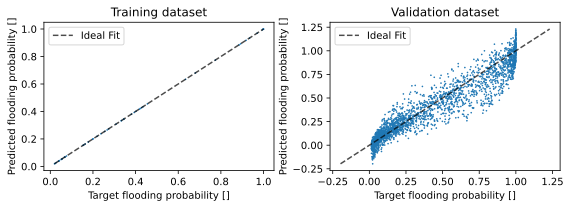

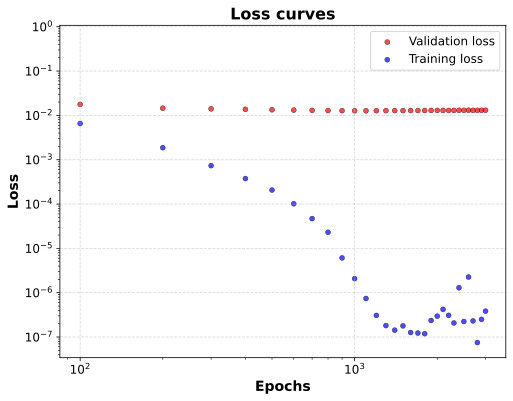

In [18]:
features = np.array([
                     data['rainfall_mm'],
                     data['flood_defense_quality'],
                     data['impervious_surface_pct'],
                     data['soil_permeability_mm_per_hr'],
                     data['groundwater_level_m'],
                    ]).transpose()

targets = data['flooding_probability'].to_numpy().reshape(-1,1)

X_train, X_val_test, t_train, t_val_test = train_test_split(features, targets, test_size=0.99, random_state=42)
X_val, X_test, t_val, t_test = train_test_split(X_val_test, t_val_test, test_size=0.50, random_state=24)

scaler_x = MinMaxScaler()
scaler_x.fit(X_train)

normalized_X_train = scaler_x.transform(X_train)
normalized_X_val = scaler_x.transform(X_val)

scaler_t = MinMaxScaler()
scaler_t.fit(t_train)

normalized_t_train = scaler_t.transform(t_train)
normalized_t_val = scaler_t.transform(t_val)

model = MLPRegressor(hidden_layer_sizes = (50,50,50), 
                    activation = 'relu')

epoch_list, train_loss_list, val_loss_list = train_model(model,
                                                         normalized_X_train,
                                                         normalized_t_train,
                                                         normalized_X_val,
                                                         normalized_t_val,
                                                         n_epochs=3000,
                                                         batch_size=64,
                                                         learning_rate=0.001,
                                                         verbose=False)

# Compute y for the whole training dataset and then denormalize it for plotting
y_train = scaler_t.inverse_transform(model.predict(normalized_X_train).reshape(-1,1))

# Compute y for the whole validation dataset and then denormalize it for plotting
y_val = scaler_t.inverse_transform(model.predict(normalized_X_val).reshape(-1,1))

# Set up the plots
fig,axes = plt.subplots(1,2,figsize=(8,3))

axes[0].set_title('Training dataset')
axes[0].set_xlabel('Target flooding probability []')
axes[0].set_ylabel('Predicted flooding probability []')
axes[1].set_title('Validation dataset')
axes[1].set_xlabel('Target flooding probability []')
axes[1].set_ylabel('Predicted flooding probability []')

# Plot predictions versus targets for both sets
axes[0].scatter(t_train,y_train,s=0.5)
axes[1].scatter(t_val,y_val,s=0.5)

# Plot 'ideal fit' diagonal lines
min_val = min(np.min(t_train), np.min(y_train))
max_val = max(np.max(t_train), np.max(y_train))
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[0].legend()

min_val = min(np.min(t_val), np.min(y_val))
max_val = max(np.max(t_val), np.max(y_val))
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[1].legend()

# Wrap up
plt.tight_layout()
plt.show()

# Initialize figure
ax = plt.figure(figsize=(8, 6)).gca()

# Create a scatter plot
plt.scatter(epoch_list, val_loss_list, label='Validation loss', color='red', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)
plt.scatter(epoch_list, train_loss_list, label='Training loss', color='blue', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)

# Add labels and a legend
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Loss curves', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)

# Switch to log-log plot
plt.yscale('log')
plt.xscale('log')

# Customize the grid appearance
plt.grid(True, linestyle='--', alpha=0.5)

# Customize the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Wrap up
plt.show()

<div style="background-color:#FFC5CB; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>
    
10) Looking at all of your new plots, what are the signs this new model is suffering from overfitting? What is the root cause for the overfitting?

</div>

## Model Selection
Okay, so we have just seen that too complex models might be a problem. But it also makes sense that too rigid models should also be avoided. So **how large does the model need to be in the end?**

Let us try to see whether we can find a reasonable model size by trying out different numbers of layers and layer sizes. This is a process which we called **Model Selection** during the lectures. The crucial point is that we should look exclusively at the validation loss when selecting models, as minimizing training loss will always lead to overfitting.

<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">

<b>Task 6:</b>

For this final task **go back to splitting the dataset 80%/10%/10%**. Keep the input features the same as in the previous tasks.

Now use a grid-search strategy to find hyperparameters that give the best prediction on the validation set. Vary the number of layers and number of hidden units per layer. You can assume that all the hidden layers have the same number of hidden units.

Set up lists for `layer_sizes` and `layer_numbers` to create a grid of models to be tested. You can also set the number of networks `n_models` to be trained for each architecture. Since network weights are initialized randomly, every trained model is unique and the loss might therefore fluctuate. This code will take an average of the losses for each architecture. You do not need to code anything else. 

Do not be too ambitious with your setup, the number of models to be trained is `n_trainings*len(layer_sizes)*len(layer_numbers)`, so if you use too many combinations the block will take a while to run. As a general tip, avoid using more than three hidden layers, more than 100 units per layer and more than 5 models per architecture. **Start slow!**

On the second block we plot the final validation losses of all the models on a grid as a kind of heatmap. Add this plot to your report.
</div>

In [20]:
# Split the dataset 80/10/10%
X_train, X_val_test, t_train, t_val_test = train_test_split(features, targets, test_size=0.20, random_state=42)
X_val, X_test, t_val, t_test = train_test_split(X_val_test, t_val_test, test_size=0.50, random_state=24)

# Fit normalizers
scaler_x = MinMaxScaler()
scaler_x.fit(X_train)

scaler_t = MinMaxScaler()
scaler_t.fit(t_train)

# Normalize the datasets
normalized_X_train = scaler_x.transform(X_train)
normalized_X_val = scaler_x.transform(X_val)

normalized_t_train = scaler_t.transform(t_train)
normalized_t_val = scaler_t.transform(t_val)

# Models to try
layer_sizes = [5, 20, 50, 100] 
layer_numbers = [1, 2, 3, 4]
n_models = 5

# Create a grid for the coordinate pairs and store them in an array
val_loss_grid = np.zeros((len(layer_sizes), len(layer_numbers)))

# Loop over all the layer sizes
for i, lsize in enumerate(layer_sizes):
    
    # Loop over all numbers of hidden layers
    for j, lnumber in enumerate(layer_numbers):
    
        # get tuple of hidden layer sizes
        layers = (lsize,) * lnumber
        print("Training NN with hidden layers:  {}".format(layers))
        
        # Create the ANN model with the given architecture
        # Changing random_state guarantees each trained network will have unique weights
        for k in range(n_models):
            model = MLPRegressor(hidden_layer_sizes=layers, activation='relu', random_state=k, alpha=0)
            
            _, _,  val_loss_list = train_model(model, 
                                               normalized_X_train, 
                                               normalized_t_train,
                                               normalized_X_val, 
                                               normalized_t_val, 
                                               n_epochs=200, 
                                               batch_size=64,
                                               learning_rate=0.001,
                                               verbose=False
                                               )
        
            print("  Model",k,"validation loss: {:.4e}".format(val_loss_list[-1]))
            val_loss_grid[i,j] += val_loss_list[-1]/float(n_models)
        
        print("     Average validation loss:    {:.4e}\n".format(val_loss_grid[i,j]))


# Extract the hyperparameters that gave the lowest loss and print
min_size, min_number = np.unravel_index(np.argmin(val_loss_grid), val_loss_grid.shape)
print("\n\nModel with {} layers and {} neurons per layer gave lowest loss of {:.4e}".format(layer_numbers[min_number], layer_sizes[min_size], val_loss_grid[min_size, min_number]))

Training NN with hidden layers:  (5,)
  Model 0 validation loss: 1.0691e-02
  Model 1 validation loss: 7.6450e-03
  Model 2 validation loss: 1.6362e-02
  Model 3 validation loss: 1.6479e-02
  Model 4 validation loss: 1.3331e-02
     Average validation loss:    1.2901e-02

Training NN with hidden layers:  (5, 5)
  Model 0 validation loss: 1.1259e-02
  Model 1 validation loss: 5.9932e-03
  Model 2 validation loss: 1.0975e-02
  Model 3 validation loss: 8.3493e-03
  Model 4 validation loss: 4.6254e-03
     Average validation loss:    8.2404e-03

Training NN with hidden layers:  (5, 5, 5)
  Model 0 validation loss: 8.2475e-03
  Model 1 validation loss: 6.3147e-03
  Model 2 validation loss: 6.6332e-03
  Model 3 validation loss: 5.6846e-03
  Model 4 validation loss: 5.2408e-03
     Average validation loss:    6.4242e-03

Training NN with hidden layers:  (5, 5, 5, 5)
  Model 0 validation loss: 6.7701e-03
  Model 1 validation loss: 7.1741e-03
  Model 2 validation loss: 1.0991e-02
  Model 3 vali

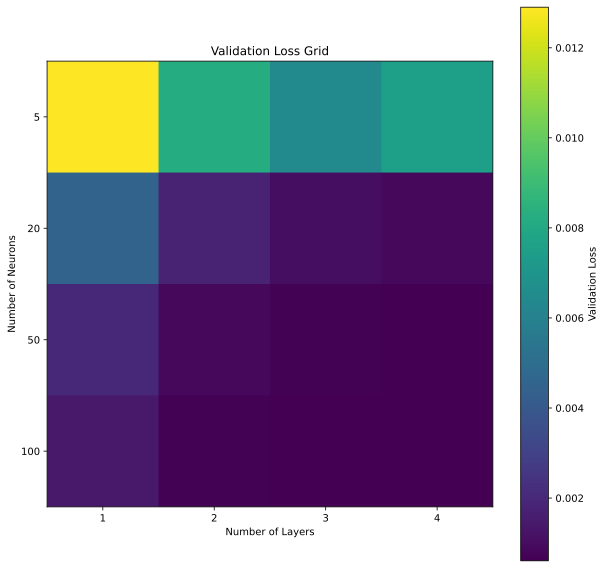

In [21]:
# Define the row and column labels
rows = layer_sizes
cols = layer_numbers

plt.figure(figsize=(10, 10))
plt.imshow(val_loss_grid, cmap='viridis', interpolation='nearest')

# Add a colorbar
plt.colorbar(label='Validation Loss')

# Colorbar range, you can tweak this to soften the influence of very high or very low values
# plt.clim(0.01,0.001)

# Add the row and column labels
plt.xticks(range(len(cols)), cols)
plt.yticks(range(len(rows)), rows)

plt.xlabel('Number of Layers')
plt.ylabel('Number of Neurons')

plt.title('Validation Loss Grid')
plt.show()

<div style="background-color:#FFC5CB; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>
    
11) Given a comprehensive list of layer sizes and numbers, we would in theory expect the top left region of the heatmap to have high validation errors. Why is that?

12) Following up on the previous question, we would also expect the bottom right region of the heatmap to have high validation errors since those models would suffer from overfitting. Why do we not see it happening here? Think about what changed between Task 5 and Task 6.

</div>

> By Iuri Rocha, Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html)